# Fine tuning an image classifier

Given a photo library and a set of photos, can we find similar ones?
For example if we want to find some pictures of artwork, can we find them all given a sample of a few images?

Method:

* Create a sample dataset
* Use a pretrained image classifier from Torchvision
* Fine tune the model on part of the sample dataset
* Predict all the images from the dataset and find matching images

### Load images

Create data loaders

In [1]:
from pathlib import Path

image_path = Path().absolute() / "images"


In [2]:
import torch
import torchvision
import torch.utils.data

# Define the transforms to be applied to the data
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

# Load the dataset using the ImageFolder class
dataset = torchvision.datasets.ImageFolder(root=str(image_path), transform=transform)

# Split the dataset into train and test sets
train_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.2])

# Define the data loaders for train and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=2, shuffle=False, num_workers=4)


Show a few examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_48717/240292381.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


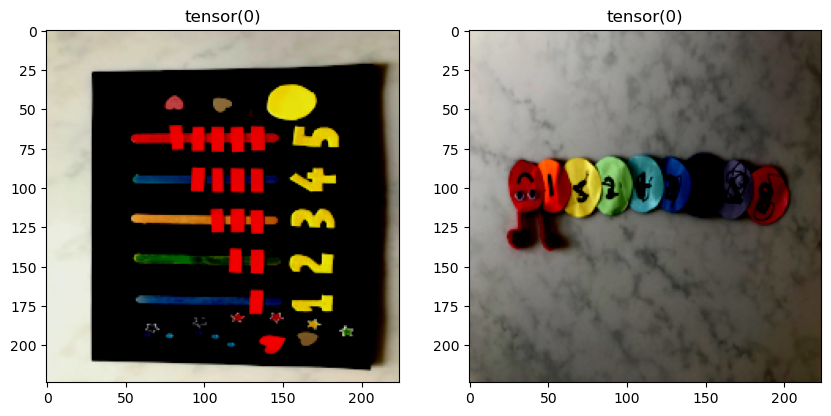

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def get_np_image_from_batch(img_batch, idx):
    img = img_batch.cpu().numpy()[idx]
    # convert image back to Height,Width,Channels
    img = np.transpose(img, (1, 2, 0))
    return img


# get first batch
img_batch, labels_batch = next(iter(train_loader))

n_images = 2
fig, ax = plt.subplots(figsize=(10, 6), ncols=n_images)
for _idx in range(n_images):
    ax[_idx].imshow(get_np_image_from_batch(img_batch, _idx))
    ax[_idx].set_title(labels_batch[_idx])
fig.show()


### Get imagenet classifier
Imagenet is a commonly used dataset of about 1 million images and labels of about 1000 classes.

We're using an EfficientNet-B0 as it has similar performance to other models such as ResNet-50 and InceptionV3 but about 20% of the parameters.

In [4]:
import torchvision.models as models

# Load pre-trained EfficientNet model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)


We need to change the final layer from the original 1000 classes to a binary classification task.
The final layer takes in 1280 features and outputs log probs for 1000 classes.

In [5]:
import torch.nn as nn

# Replace last fully-connected layer
num_classes = 2  # example number of output classes
# get number of input features for new layer
in_features = model.classifier[1].in_features
# replace last fully-connected layer
model.classifier[1] = nn.Linear(in_features, num_classes)


### Fine tune

We only want to retrain the final few layers so we freeze the early layers.

In [6]:
# Freeze some layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last few layers
for param in model.features[-2:].parameters():
    param.requires_grad = True


Now we setup a training routine as normal

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [8]:
# Train the model
num_epochs = 5  # example number of epochs
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        print(f"loss: {loss}")

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    # ...


epoch: 0
loss: 0.6749622225761414
loss: 0.6522541046142578
loss: 0.6532810926437378
loss: 0.7893743515014648
loss: 0.6235467195510864
loss: 0.5929502248764038
loss: 0.7317588329315186
loss: 0.7135790586471558
loss: 0.5895956158638
loss: 0.7289503216743469
loss: 0.7473368048667908
loss: 0.7478780150413513
loss: 0.659546971321106
loss: 0.8128130435943604
loss: 0.5993536710739136
loss: 0.5851114988327026
loss: 0.6244693994522095
loss: 0.7405709028244019
loss: 0.6427725553512573
loss: 0.6863744258880615
loss: 0.6231130361557007
loss: 0.6750810742378235
loss: 0.7119606733322144
loss: 0.7021406888961792
loss: 0.5612386465072632
loss: 0.6277965903282166
loss: 0.7070862054824829
loss: 0.6190944910049438
loss: 0.5953423976898193
loss: 0.7061189413070679
loss: 0.7141381502151489
loss: 0.7081596851348877
loss: 0.5961926579475403
loss: 0.6622515916824341
loss: 0.7377122640609741
loss: 0.7078201770782471
epoch: 1
loss: 0.6407105922698975
loss: 0.6032626628875732
loss: 0.7335724830627441
loss: 0.752

In [9]:
# Evaluate the model
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print("Train Accuracy: {:.2f}%".format(accuracy))


    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print("Test Accuracy: {:.2f}%".format(accuracy))


Train Accuracy: 77.78%
Test Accuracy: 76.47%


## With pytorch lightning

In [4]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.models as models
from torch import nn
from torch.utils.data import DataLoader


class FineTuningModel(pl.LightningModule):
    def __init__(self, num_classes=2, learning_rate=0.01):
        super().__init__()

        # Load pre-trained EfficientNet model
        backbone = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )

        # recreate as pytorch module
        self.features = nn.Sequential(*list(backbone.children())[:-1])

        # Replace last fully-connected layer
        # get number of input features for new layer
        in_features = list(backbone.children())[-1][1].in_features
        # replace last fully-connected layer
        self.classifier = nn.Linear(in_features, num_classes)

        # Freeze some layers
        for param in self.features.parameters():
            param.requires_grad = False

        # Unfreeze last few layers
        for param in self.features[0][-1:].parameters():
            param.requires_grad = True

        # Define loss function
        self.criterion = nn.CrossEntropyLoss()

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.SGD(
            self.parameters(), lr=learning_rate, momentum=0.9
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True)

        # Calculate validation accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = torch.sum(preds == y) / len(y)
        self.log("val_acc", acc, prog_bar=True, on_step=True)

    def configure_optimizers(self):
        return self.optimizer


Try with small dataset

In [5]:
model_lightning = FineTuningModel()
outputs = model_lightning(img_batch)
outputs

tensor([[-0.0596,  0.0033],
        [-0.0140, -0.2130]], grad_fn=<AddmmBackward0>)

Train model

In [6]:
model_lightning = FineTuningModel()
trainer = pl.Trainer(max_epochs=5, enable_progress_bar=True, accelerator="cpu")
trainer.fit(model_lightning, train_loader, test_loader)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: /Users/rich/Developer/Github/VariousDataAnalysis/Unpublished/image_fine_tune_classifier/lightning_logs

  | Name       | Type             | Params
------------------------------------------------
0 | features   | Sequential       | 4.0 M 
1 | classifier | Linear           | 2.6 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
414 K     Trainable params
3.6 M     Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 4: 100%|██████████| 36/36 [00:55<00:00,  1.54s/it, v_num=0, train_loss=0.946, val_loss_step=0.00113, val_acc_step=1.000, val_loss_epoch=0.0363, val_acc_epoch=1.000]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 36/36 [00:55<00:00,  1.54s/it, v_num=0, train_loss=0.946, val_loss_step=0.00113, val_acc_step=1.000, val_loss_epoch=0.0363, val_acc_epoch=1.000]


## Evaluate with all images

Evaluate train and test data loaders

In [21]:
def predict_data_loader(model, data_loader):
    model.eval()

    y_est = []
    y_true = []
    with torch.no_grad():
        for img_batch, label_batch in train_loader:
            output = model(img_batch)
            probs = torch.nn.functional.softmax(output, dim=1)
            
            y_est.append(probs)
            y_true.append(label_batch)

    y_est = torch.cat(y_est, dim=0)
    y_true = torch.cat(y_true, dim=0)

    return y_est, y_true

y_est_train, y_true_train = predict_data_loader(model_lightning, train_loader)
y_est_test, y_true_test = predict_data_loader(model_lightning, test_loader)

In [38]:
import sklearn.metrics

print(sklearn.metrics.log_loss(y_true_train, y_est_train))
print(sklearn.metrics.log_loss(y_true_test, y_est_test))
print(sklearn.metrics.accuracy_score(y_true_train, y_est_train[:,1]>y_est_train[:,0]))
print(sklearn.metrics.accuracy_score(y_true_test, y_est_test[:,1]>y_est_test[:,0]))

0.045401007159378476
0.045027754386167976
0.9861111111111112
0.9861111111111112


What did it get wrong?

In [43]:
y_true_train != (y_est_train[:,1]>y_est_train[:,0])

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [45]:
train_loader.dataset

Specific images

In [7]:
from PIL import Image

image_paths = ["images/other/68364009651__BF66A2EF-0DC5-4AE7-B389-2694C17BED69.jpeg", "images/art/IMG_2759.JPG"]
for image_path in image_paths:
    img = Image.open(image_path)
    img = transform(img)

    # Add a batch dimension to the image
    img = img.unsqueeze(0)

    # Pass the image through the model
    output = model_lightning(img)

    # Convert the output to probabilities
    probs = torch.nn.functional.softmax(output, dim=1)

    # Print the top 5 predicted classes and their probabilities
    print(probs)


tensor([[0.1394, 0.8606]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward0>)


SHAP on images to find key elements?
Is the background key?